### Comparison of LR, KNN, and SVM on classifying the Iris dataset
This program compares the accuracy, training time, test time, and memory usage of the three supervised machine learning models used for classification:
* Logistic regression
* K Nearest Neighbor
* Support vector machine

In [1]:
import pandas as pd
import numpy as np

from time import time
from memory_profiler import memory_usage
from IPython.display import display

from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from plotnine import ggplot, aes, geom_boxplot, geom_text, facet_wrap, labs, theme, element_text, position_dodge, geom_bar

# Load the Iris dataset and save it into a dataframe
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names) # Add species information to the DataFrame
target_names = iris.target_names

# Display summary statistics for exploratory data analysis
display(iris_df.head())
display(iris_df.describe())

# Display count by species to see if all species are represented equally
species_counts_df = iris_df['species'].value_counts().reset_index()
species_counts_df.columns = ['Species', 'Count']  # Rename columns for clarity
display(species_counts_df)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


,Species,Count
0,setosa,50
1,versicolor,50
2,virginica,50


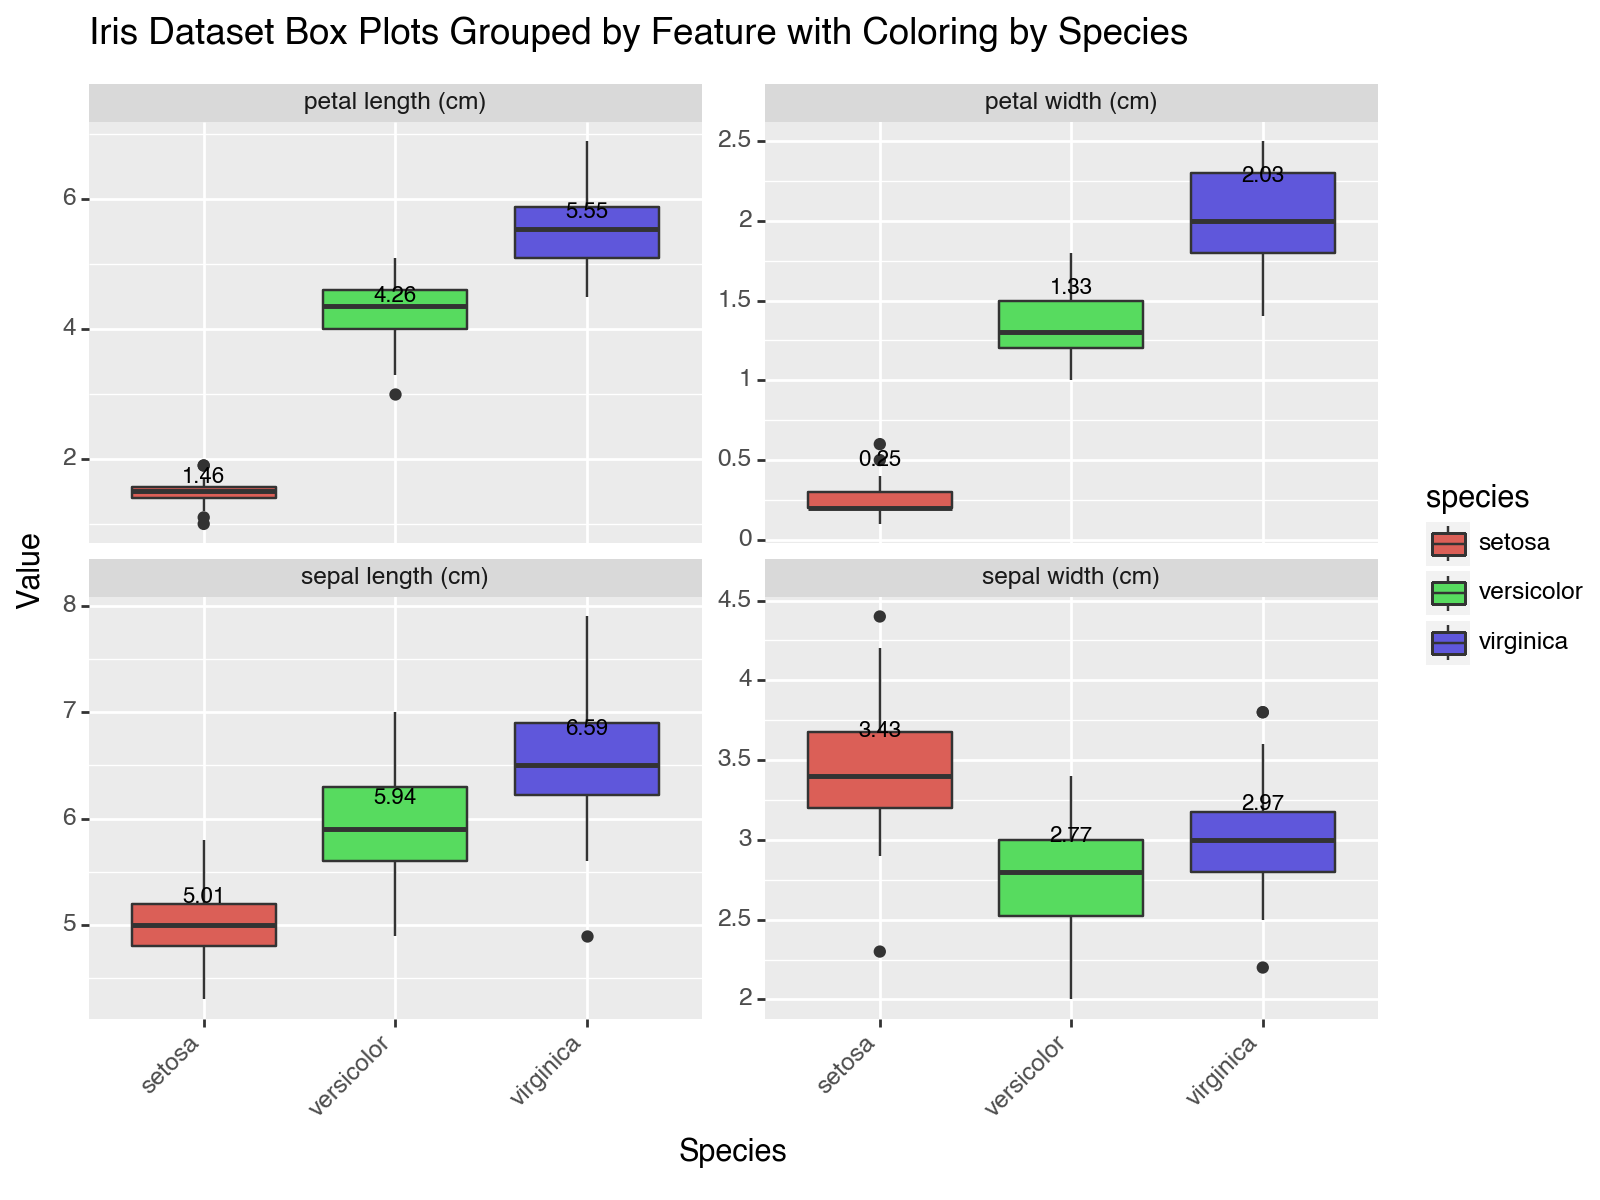

<Figure Size: (800 x 600)>

In [2]:
# Visualize all x variables with box plots

# Convert the DataFrame to a long format suitable for plotting
iris_long_df = iris_df.melt(id_vars="species", var_name="feature", value_name="value")

# Calculate means for each combination of feature and species
mean_values = iris_long_df.groupby(['feature', 'species'], observed=True)['value'].mean().reset_index()
mean_values['value_str'] = mean_values['value'].apply(lambda x: f'{x:.2f}')

# Create the plot with boxplot and mean values annotated, grouping by feature
plot = (
    ggplot(iris_long_df, aes(x='species', y='value', fill='species')) +  # Maintain coloring by species
    geom_boxplot() +
    geom_text(data=mean_values, mapping=aes(x='species', y='value', label='value_str'),
              position=position_dodge(width=0.75), nudge_y=0.25, size=8, ha='center') +
    facet_wrap('~ feature', scales='free_y') +  # Group plots by 'feature'
    labs(title='Iris Dataset Box Plots Grouped by Feature with Coloring by Species', x='Species', y='Value') +
    theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
)

plot

In [3]:
# Optional: filter outliers

print("Original DataFrame size:", iris_df.shape)

# Function to remove outliers based on the IQR method for a given column
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Apply the function to each numeric column - change to True to filter
if False:
    for column in iris_df.select_dtypes(include='number').columns:
        iris_df = remove_outliers(iris_df, column)

print("Filtered DataFrame size:", iris_df.shape)

Original DataFrame size: (150, 5)
Filtered DataFrame size: (150, 5)


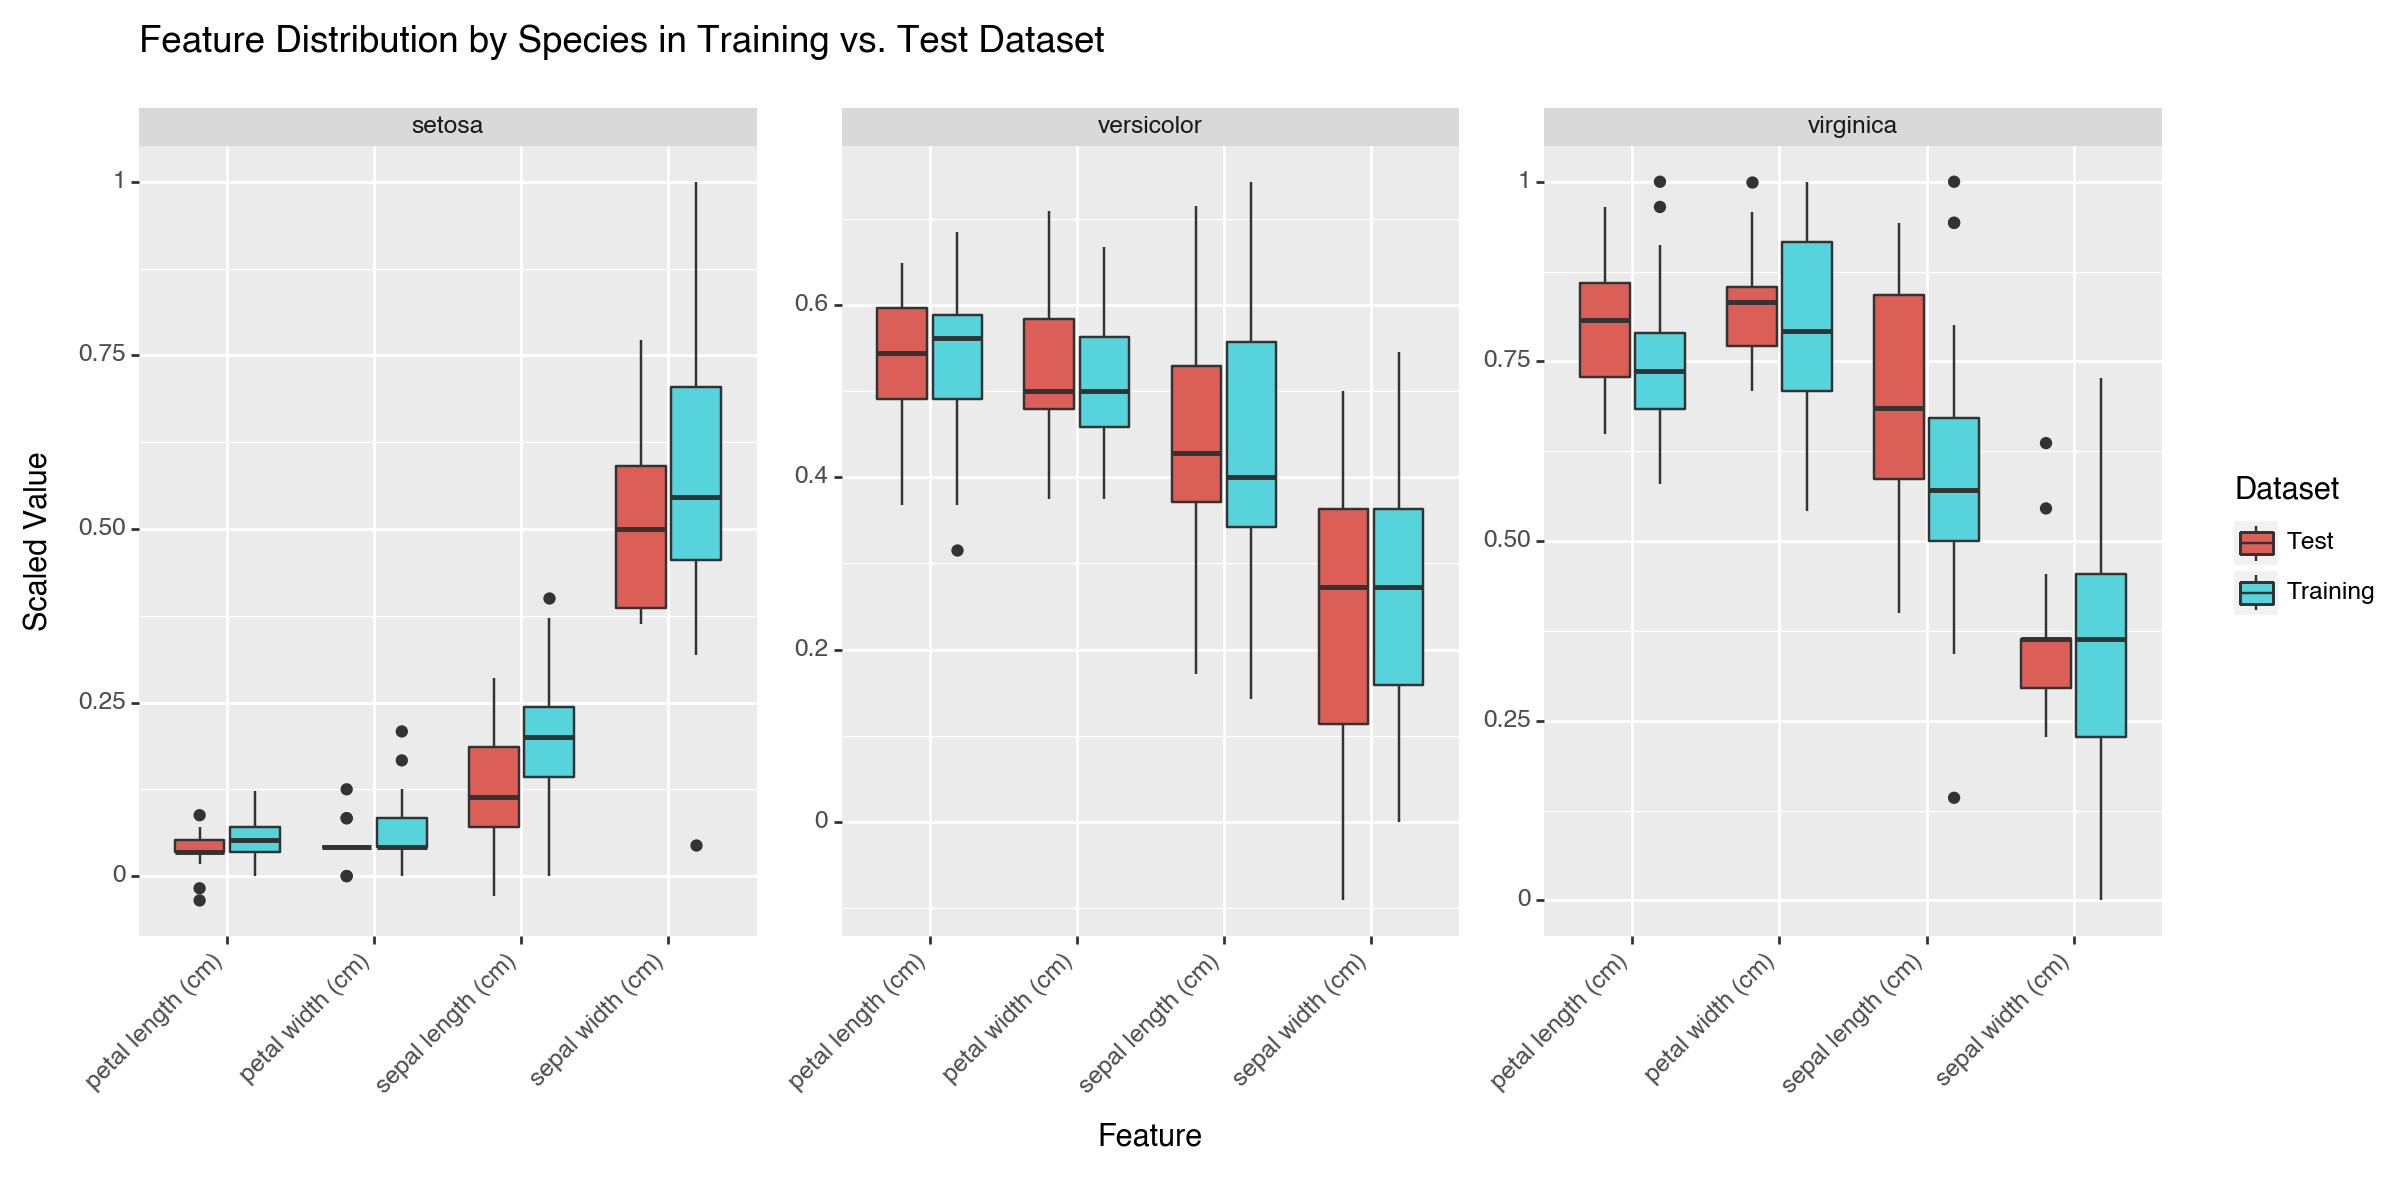

<Figure Size: (1200 x 600)>

Training set class distribution:


,Class,Count
0,1,35
1,2,35
2,0,35


Test set class distribution:


,Class,Count
0,2,15
1,0,15
2,1,15


In [4]:
# Prepare the data for training and validation

# Specify ratio of training to validation and the prng seed
# random_state = prng seed, changing this may change accuracy results
# stratify = ensure there are equal numbers of training dataset for each species
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=12, stratify=iris.target) 

# Normalize x_train and x_test
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert scaled data back to DataFrame and reintegrate species information
train_df = pd.DataFrame(x_train, columns=iris.feature_names)
train_df['species'] = [iris.target_names[i] for i in y_train]  # Map numeric labels to species names
train_df['Dataset'] = 'Training'

test_df = pd.DataFrame(x_test, columns=iris.feature_names)
test_df['species'] = [iris.target_names[i] for i in y_test]  # Map numeric labels to species names
test_df['Dataset'] = 'Test'

# Combine the training and test dataframes
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Melt the DataFrame for plotting
melted_df = combined_df.melt(id_vars=["species", "Dataset"], var_name="Feature", value_name="Value")

# Plot with boxplot, grouped by species and dataset to check if training and test datasets are significantly different
plot = (
    ggplot(melted_df, aes(x='Feature', y='Value', fill='Dataset')) +
    geom_boxplot() +
    facet_wrap('~ species', scales='free_y', ncol=3) +  # Separate plot for each species
    labs(title='Feature Distribution by Species in Training vs. Test Dataset', x='Feature', y='Scaled Value') +
    theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(12, 6))
)

display(plot)

# Check that there are equal numbers of training dataset for each species
train_dist_df = pd.DataFrame(pd.Series(y_train).value_counts(normalize=False)).reset_index()
train_dist_df.columns = ['Class', 'Count']
test_dist_df = pd.DataFrame(pd.Series(y_test).value_counts(normalize=False)).reset_index()
test_dist_df.columns = ['Class', 'Count']

print("Training set class distribution:")
display(train_dist_df)
print("Test set class distribution:")
display(test_dist_df)


In [5]:
# Print helper function that prints results in-line
def print_function(results):
    print(f"Model: {results['model_name']}")
    print(f"Accuracy: {results['accuracy']}")
    print(f"Training Time: {results['training_time']}s")
    print(f"Test Time: {results['test_time']}s")
    print(f"Max Memory Usage: {results['max_memory_usage']}MB")
    print("\nConfusion Matrix:")
    print(results['confusion_matrix_df'])
    if 'parameters' in results:
        print(f"\nparameters: {results['parameters']}")
    if 'best parameters' in results:
        print(f"\nBest parameters: {results['best parameters']}")
        print(f"Best score: {results['best score']}")

# Runs a specified model with default hyper-parameters
def run_model(model, x_train, y_train, x_test, y_test, target_names, print_results=False):
    """
    Fits the given model on the training data, evaluates it on the test data,
    and stores the results in a dictionary

    Parameters:
    - model: The machine learning model to be evaluated such as:
    -        LogisticRegression(),
    -        KNeighborsClassifier(),
    -        SVC(kernel='linear')
    - x_train: Training data features
    - y_train: Training data labels
    - x_test: Test data features
    - y_test: Test data labels
    - target_names: List of target class names for confusion matrix indexing

    Returns:
    A dictionary containing the model name, confusion matrix DataFrame, and accuracy.
    """
    
    start_train_time = time()
    peak_memory_start = memory_usage(max_usage=True)
    
    model.fit(x_train, y_train)
    
    training_time = time() - start_train_time
    peak_memory_end_train = memory_usage(max_usage=True)
    
    start_test_time = time()
    y_pred = model.predict(x_test)
    test_time = time() - start_test_time
    peak_memory_end_test = memory_usage(max_usage=True)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)
    accuracy = accuracy_score(y_test, y_pred)
    
    results = {
        'model_name': model.__class__.__name__,
        'confusion_matrix_df': conf_matrix_df,
        'accuracy': accuracy,
        'parameters': model.get_params(),
        'training_time': training_time,
        'test_time': test_time,
        'max_memory_usage': max(peak_memory_end_train - peak_memory_start, peak_memory_end_test - peak_memory_start)
    }
    
    if print_results:
        print_function(results)

    return results

# Runs a specified model that optimizes hyperparmeters specied in params
def run_cv_model(search_method, pipeline, params, x_train, y_train, x_test, y_test, target_names, print_results=False):
    """
    Run_model expanded to run grid or randomized search cross validation to optimize hyperparameters

    Additional Parameters:
    - search_method: Search method to optimize hyperparameters - GridSearchCV() or RandomizedSearchCV()
    - pipeline: Pipeline with preprocessing and model
    - params: Dictionary of hyperparameters and their allowed values/ranges

    Returns:
    A dictionary containing the model name, confusion matrix DataFrame, and accuracy.
    """
    
    peak_memory_start = memory_usage(max_usage=True)
    start_cv_time = time()
    
    search = search_method(pipeline, params, cv=5, scoring='accuracy', verbose=1)
    search.fit(x_train, y_train)
    
    cv_time = time() - start_cv_time
    peak_memory_end_cv = memory_usage(max_usage=True)
    
    start_test_time = time()
    test_accuracy = search.score(x_test, y_test)
    test_time = time() - start_test_time
    peak_memory_end_test = memory_usage(max_usage=True)
    
    y_pred = search.predict(x_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)
    
    results = {
        'model_name': search.best_estimator_.steps[-1][1].__class__.__name__,
        'confusion_matrix_df': conf_matrix_df,
        'accuracy': test_accuracy,
        'best parameters': search.best_params_,
        'best score': search.best_score_,
        'training_time': cv_time,
        'test_time': test_time,
        'max_memory_usage': max(peak_memory_end_cv - peak_memory_start, peak_memory_end_test - peak_memory_start)
    }
    
    if print_results:
        print_function(results)

    return results


In [6]:
# Run log reg classifer (default) and evaluate its accuracy

results = {}
results['LogReg'] = run_model(LogisticRegression(), x_train, y_train, x_test, y_test, target_names, print_results=True)

Model: LogisticRegression
Accuracy: 0.9333333333333333
Training Time: 0.10566091537475586s
Test Time: 0.00041174888610839844s
Max Memory Usage: 0.546875MB

Confusion Matrix:
            setosa  versicolor  virginica
setosa          15           0          0
versicolor       0          12          3
virginica        0           0         15

parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [7]:
# Run log reg classifier (auto-optimization with gridsearchcv) and evaluate its accuracy

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('logreg', LogisticRegression())  # Logistic Regression classifier
])

# Define the parameter grid to search
param_grid = {
    'logreg__C': [0.1, 1, 10],  # Regularization parameter
    'logreg__solver': ['liblinear', 'saga', 'lbfgs'],  # Solver
    'logreg__max_iter': [500, 1000, 10000]  # Maximum number of iterations
}

results['LogReg_Optimized'] = run_cv_model(GridSearchCV, pipeline, param_grid,
                                            x_train, y_train, x_test, y_test, target_names, print_results=True)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Model: LogisticRegression
Accuracy: 0.9777777777777777
Training Time: 0.20826983451843262s
Test Time: 0.0004029273986816406s
Max Memory Usage: 0.59375MB

Confusion Matrix:
            setosa  versicolor  virginica
setosa          15           0          0
versicolor       0          14          1
virginica        0           0         15

Best parameters: {'logreg__C': 10, 'logreg__max_iter': 500, 'logreg__solver': 'saga'}
Best score: 0.9619047619047618


In [8]:
# Run k-nearest neighbor classifier (default) and evaluate its accuracy

results['KNN'] = run_model(KNeighborsClassifier(), x_train, y_train, x_test, y_test, target_names, print_results=True)

Model: KNeighborsClassifier
Accuracy: 0.9777777777777777
Training Time: 0.10718393325805664s
Test Time: 0.008386850357055664s
Max Memory Usage: 0.21875MB

Confusion Matrix:
            setosa  versicolor  virginica
setosa          15           0          0
versicolor       0          14          1
virginica        0           0         15

parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [9]:
# Run k-nearest neighbor classifier (auto-optimization with gridsearchcv) and evaluate its accuracy

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('knn', KNeighborsClassifier())  # KNN classifier
])

# Define the parameter grid to search
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors
    'knn__weights': ['uniform', 'distance'],  # Weighting function
    'knn__p': [1, 2],  # Power parameter for the Minkowski metric
}

results['KNN_Optimized'] = run_cv_model(GridSearchCV, pipeline, param_grid,
                                        x_train, y_train, x_test, y_test, target_names, print_results=True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Model: KNeighborsClassifier
Accuracy: 0.9777777777777777
Training Time: 0.14741301536560059s
Test Time: 0.002051830291748047s
Max Memory Usage: 0.09375MB

Confusion Matrix:
            setosa  versicolor  virginica
setosa          15           0          0
versicolor       0          14          1
virginica        0           0         15

Best parameters: {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'uniform'}
Best score: 0.9428571428571428


In [10]:
# Run svm classifier (default) and evaluate its accuracy

results['SVM'] = run_model(SVC(kernel='linear'), x_train, y_train, x_test, y_test, target_names, print_results=True)

Model: SVC
Accuracy: 1.0
Training Time: 0.10407233238220215s
Test Time: 0.0005698204040527344s
Max Memory Usage: 0.078125MB

Confusion Matrix:
            setosa  versicolor  virginica
setosa          15           0          0
versicolor       0          15          0
virginica        0           0         15

parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [11]:
# Run svm classifier (auto-optimization with gridsearchcv) and evaluate its accuracy

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('svm', SVC())  # SVM classifier
])

# Define the parameter grid to search
param_grid = {
    'svm__C': [0.1, 1, 10],  # Regularization parameter
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Type of kernel
    'svm__gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

results['SVM_Optimized'] = run_cv_model(GridSearchCV, pipeline, param_grid,
                                        x_train, y_train, x_test, y_test, target_names, print_results=True)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model: SVC
Accuracy: 0.9777777777777777
Training Time: 0.14316296577453613s
Test Time: 0.0004220008850097656s
Max Memory Usage: 0.03125MB

Confusion Matrix:
            setosa  versicolor  virginica
setosa          15           0          0
versicolor       0          14          1
virginica        0           0         15

Best parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best score: 0.9428571428571428


In [12]:
# Summarize results
# Note that with small datasets such as iris, default models may outperform optimized models
# This is because the optimized models split the training dataset further into internal 
# training and validation datasets to optimize their hyper parameters

data = []
for key, value in results.items():
    if value is not None:
        data.append({
            'Model': key,
            'Accuracy': value['accuracy'],
            'Training Time': value['training_time'],
            'Test Time': value['test_time'],
            'Max Memory Usage': value['max_memory_usage']
        })

# Convert the data list to a DataFrame
results_df = pd.DataFrame(data)

display(results_df.sort_values(by='Accuracy', ascending=False))

,Model,Accuracy,Training Time,Test Time,Max Memory Usage
4,SVM,1.000000,0.104072,0.000570,0.078125
1,LogReg_Optimized,0.977778,0.208270,0.000403,0.593750
2,KNN,0.977778,0.107184,0.008387,0.218750
3,KNN_Optimized,0.977778,0.147413,0.002052,0.093750
5,SVM_Optimized,0.977778,0.143163,0.000422,0.031250
0,LogReg,0.933333,0.105661,0.000412,0.546875


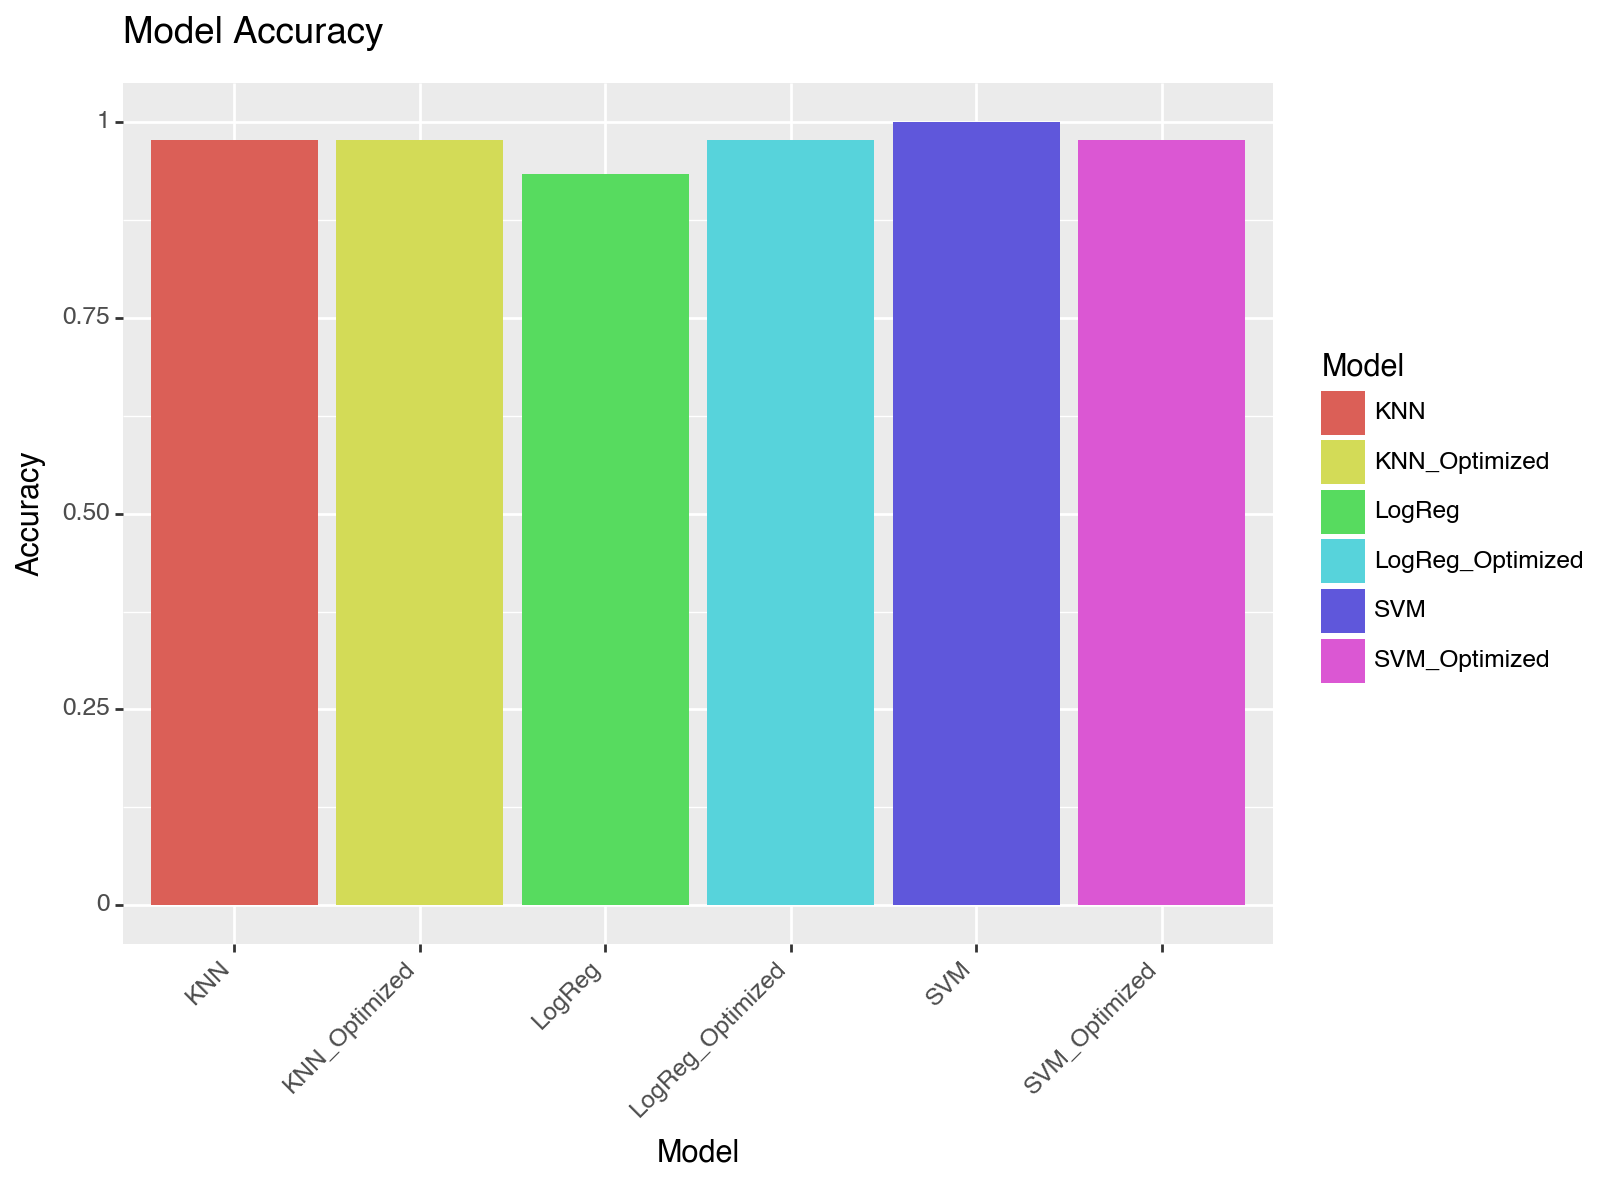

<Figure Size: (800 x 600)>

In [13]:
# Plot the accuracy

accuracy_plot = (
    ggplot(results_df, aes(x='Model', y='Accuracy', fill='Model')) +
    geom_bar(stat='identity') +
    labs(title='Model Accuracy', y='Accuracy') +
    # scales.ylim((0.7, 1.01)) +
    theme(axis_text_x=element_text(rotation=45, ha='right'), figure_size=(8, 6))
)

# Display the accuracy plot
display(accuracy_plot)
